# Pyomo.DoE: Exploratory Analysis

In [1]:
import sys

# If running on Google Colab, install Pyomo and Ipopt via IDAES
on_colab = "google.colab" in sys.modules
if on_colab:
    !wget "https://raw.githubusercontent.com/dowlinglab/pyomo-doe/main/notebooks/tclab_pyomo.py"

# import TCLab model, simulation, and data analysis functions
from tclab_pyomo import (
    TCLabExperiment,
    create_model,
    extract_results,
    extract_plot_results,
    results_summary,
)

# set default number of states in the TCLab model
number_tclab_states = 2

## Load experimental data (sine test)

In [2]:
import pandas as pd

if on_colab:
    file = "https://raw.githubusercontent.com/dowlinglab/pyomo-doe/main/data/tclab_sine_test.csv"
else:
    file = '../data/tclab_sine_test.csv'
df = pd.read_csv(file)
df.head()

,Time,T1,T2,Q1,Q2
0,0.00,24.45,24.13,50.0,0.0
1,1.00,24.45,24.13,55.0,0.0
2,2.01,24.45,24.13,60.0,0.0
3,3.01,24.45,24.13,65.0,0.0
4,4.01,24.77,23.81,70.0,0.0


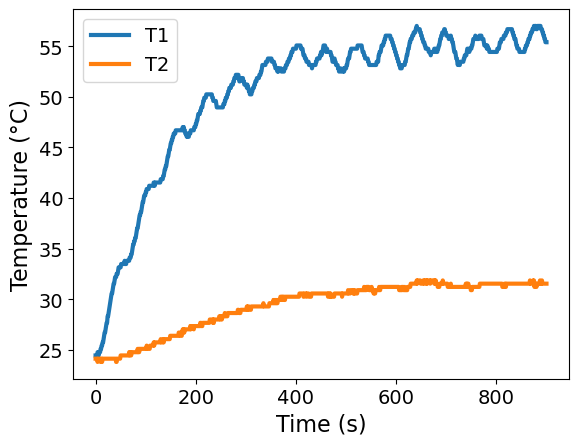

In [3]:
ax = df.plot(x='Time', y=['T1', 'T2'], xlabel='Time (s)', ylabel='Temperature (°C)')

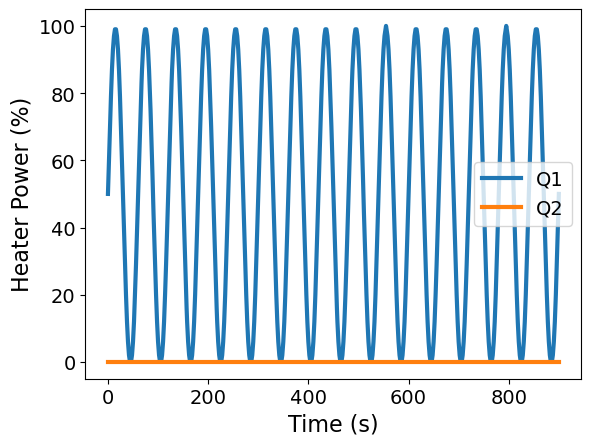

In [4]:
ax = df.plot(x='Time', y=['Q1', 'Q2'], xlabel='Time (s)', ylabel='Heater Power (%)')

In [5]:
tc_data = TCLabExperiment(
    name="Sine Wave Test for Heater 1",
    time=df['Time'].values,
    T1=df['T1'].values,
    u1=df['Q1'].values,
    P1=200,
    TS1_data=None,
    T2=df['T2'].values,
    u2=df['Q2'].values,
    P2=200,
    TS2_data=None,
    Tamb=df['T1'].values[0],
)

## Analyze FIM with Pyomo.DoE at initial point (sine test)

In [6]:
# Load Pyomo.DoE functions
from pyomo.contrib.doe import (
    ModelOptionLib,
    DesignOfExperiments,
    MeasurementVariables,
    DesignVariables,
)

from pyomo.environ import SolverFactory

# Copied from previous notebook
theta_values = {
    'Ua': 0.05147278733764012,
    'Ub': 0.0005342082856927798,
    'inv_CpH': 0.14622879403418604,
    'inv_CpS': 99.99999754623846,
}

In [7]:
# Get time points for control decisions
t_control = tc_data.time

measurements = MeasurementVariables()
measurements.add_variables('Ts1', indices={0: t_control}, time_index_position=0)

print(measurements.variable_names)

['Ts1[0.0]', 'Ts1[1.0]', 'Ts1[2.01]', 'Ts1[3.01]', 'Ts1[4.01]', 'Ts1[5.01]', 'Ts1[6.01]', 'Ts1[7.01]', 'Ts1[8.01]', 'Ts1[9.01]', 'Ts1[10.0]', 'Ts1[11.01]', 'Ts1[12.01]', 'Ts1[13.01]', 'Ts1[14.01]', 'Ts1[15.01]', 'Ts1[16.01]', 'Ts1[17.01]', 'Ts1[18.01]', 'Ts1[19.01]', 'Ts1[20.01]', 'Ts1[21.01]', 'Ts1[22.01]', 'Ts1[23.01]', 'Ts1[24.01]', 'Ts1[25.01]', 'Ts1[26.01]', 'Ts1[27.01]', 'Ts1[28.01]', 'Ts1[29.01]', 'Ts1[30.0]', 'Ts1[31.0]', 'Ts1[32.01]', 'Ts1[33.01]', 'Ts1[34.01]', 'Ts1[35.01]', 'Ts1[36.01]', 'Ts1[37.0]', 'Ts1[38.01]', 'Ts1[39.01]', 'Ts1[40.01]', 'Ts1[41.01]', 'Ts1[42.01]', 'Ts1[43.01]', 'Ts1[44.01]', 'Ts1[45.01]', 'Ts1[46.01]', 'Ts1[47.01]', 'Ts1[48.01]', 'Ts1[49.0]', 'Ts1[50.01]', 'Ts1[51.01]', 'Ts1[52.01]', 'Ts1[53.0]', 'Ts1[54.0]', 'Ts1[55.01]', 'Ts1[56.01]', 'Ts1[57.01]', 'Ts1[58.01]', 'Ts1[59.01]', 'Ts1[60.01]', 'Ts1[61.01]', 'Ts1[62.01]', 'Ts1[63.01]', 'Ts1[64.01]', 'Ts1[65.01]', 'Ts1[66.01]', 'Ts1[67.01]', 'Ts1[68.01]', 'Ts1[69.0]', 'Ts1[70.01]', 'Ts1[71.01]', 'Ts1[72.01]

In [8]:
decisions = DesignVariables()

decisions.add_variables(
    'U1',
    indices={0: t_control},
    time_index_position=0,
    lower_bounds=0,
    upper_bounds=100,
    values=tc_data.u1,
)

print(decisions.variable_names)

['U1[0.0]', 'U1[1.0]', 'U1[2.01]', 'U1[3.01]', 'U1[4.01]', 'U1[5.01]', 'U1[6.01]', 'U1[7.01]', 'U1[8.01]', 'U1[9.01]', 'U1[10.0]', 'U1[11.01]', 'U1[12.01]', 'U1[13.01]', 'U1[14.01]', 'U1[15.01]', 'U1[16.01]', 'U1[17.01]', 'U1[18.01]', 'U1[19.01]', 'U1[20.01]', 'U1[21.01]', 'U1[22.01]', 'U1[23.01]', 'U1[24.01]', 'U1[25.01]', 'U1[26.01]', 'U1[27.01]', 'U1[28.01]', 'U1[29.01]', 'U1[30.0]', 'U1[31.0]', 'U1[32.01]', 'U1[33.01]', 'U1[34.01]', 'U1[35.01]', 'U1[36.01]', 'U1[37.0]', 'U1[38.01]', 'U1[39.01]', 'U1[40.01]', 'U1[41.01]', 'U1[42.01]', 'U1[43.01]', 'U1[44.01]', 'U1[45.01]', 'U1[46.01]', 'U1[47.01]', 'U1[48.01]', 'U1[49.0]', 'U1[50.01]', 'U1[51.01]', 'U1[52.01]', 'U1[53.0]', 'U1[54.0]', 'U1[55.01]', 'U1[56.01]', 'U1[57.01]', 'U1[58.01]', 'U1[59.01]', 'U1[60.01]', 'U1[61.01]', 'U1[62.01]', 'U1[63.01]', 'U1[64.01]', 'U1[65.01]', 'U1[66.01]', 'U1[67.01]', 'U1[68.01]', 'U1[69.0]', 'U1[70.01]', 'U1[71.01]', 'U1[72.01]', 'U1[73.0]', 'U1[74.0]', 'U1[75.01]', 'U1[76.01]', 'U1[77.01]', 'U1[78.

In [9]:
def create_model_doe(theta=theta_values):
    return create_model(
        data=tc_data, mode='doe', theta=theta, number_of_states=number_tclab_states
    )

In [10]:
# Create doe_object using DesignOfExperiments
doe_object1 = DesignOfExperiments(
    theta_values,  # dictionary of parameters
    decisions,  # design variable
    measurements,  # measurement variable
    create_model_doe,  # model
    solver=SolverFactory('ipopt'),
)

result = doe_object1.compute_FIM(mode='sequential_finite', formula='central')
result.result_analysis()

Ipopt 3.13.2: 

******************************************************************************
This program contains Ipopt, a library for large-scale nonlinear optimization.
 Ipopt is released as open source code under the Eclipse Public License (EPL).
         For more information visit http://projects.coin-or.org/Ipopt
******************************************************************************

This is Ipopt version 3.13.2, running with linear solver ma27.

Number of nonzeros in equality constraint Jacobian...:   111616
Number of nonzeros in inequality constraint Jacobian.:        0
Number of nonzeros in Lagrangian Hessian.............:        0

Total number of variables............................:    39626
                     variables with only lower bounds:        0
                variables with lower and upper bounds:    23408
                     variables with only upper bounds:        0
Total number of equality constraints.................:    39626
Total number of ineq

In [11]:
results_summary(result)

======Results Summary======
Four design criteria log10() value:
A-optimality: 9.698903678286175
D-optimality: nan
E-optimality: nan
Modified E-optimality: nan

FIM:
 [[ 1.88459415e+08 -1.91393890e+08 -8.24201918e+06 -1.04121590e+03]
 [-1.91393890e+08  4.80931030e+09  6.51658566e+07  2.58102008e+04]
 [-8.24201918e+06  6.51658566e+07  1.46673544e+06  3.51179540e+02]
 [-1.04121590e+03  2.58102008e+04  3.51179540e+02  1.38519624e-01]]

eigenvalues:
 [ 4.81811358e+09  1.80716021e+08  4.06846518e+05 -2.41067013e-16]

eigenvectors:
 [[ 4.13259139e-02 -9.98655750e-01  3.12867703e-02 -1.00570603e-13]
 [-9.99053330e-01 -4.17276557e-02 -1.22982147e-02 -5.33299017e-06]
 [-1.35872064e-02  3.07489171e-02  9.99434786e-01 -2.48897567e-06]
 [-5.36175981e-06 -1.45999972e-07  2.42198261e-06  1.00000000e+00]]


/Users/adowling/DowlingLab/pyomo-doe/notebooks/tclab_pyomo.py:640: RuntimeWarning: invalid value encountered in log10
  print("D-optimality:", np.log10(result.det))
/Users/adowling/DowlingLab/pyomo-doe/notebooks/tclab_pyomo.py:641: RuntimeWarning: invalid value encountered in log10
  print("E-optimality:", np.log10(result.min_eig))
/Users/adowling/DowlingLab/pyomo-doe/notebooks/tclab_pyomo.py:642: RuntimeWarning: invalid value encountered in log10
  print("Modified E-optimality:", np.log10(result.cond))


We can see the FIM of the sine wave experiment is rank deficient with one eigenvalue that is numerically zero. We wee the corresponding eigenvector points in the direction of the 4th parameter, `inv_CpS`. This means the experiment alone does not contain enough information to uniquely estimate all of the parameters if the model.

Why does it make sense that $C_p^S$ is difficult to estimate?

## Define parameterized sine wave experiment

Can we further optimize the sine wave test to improve the information content? Let's define the parameterized sine wave as:

$$
u(t) = 50 + a \sin(\frac{2 \pi}{60 p} t)
$$

where $a$ is the amplitude (% power), $p$ is the period (minutes), $t$ is the time (seconds), and 60 is a conversion factor (seconds/minute).

Here is code from the `create_model` function defined in `tclab_pyomo.py` to calculate the parameterized control signal from the inputs `sine_amplitude` and `sine_period`:

```
# Calculate parameterized control signal for u1
u1 = 50 + sine_amplitude*np.sin(2*np.pi/(sine_period*60)*time)
```

Here is code from `create_model` in `tclab_pyomo.py` to define the parameterized sine wave in Pyomo.

```
# Add measurement control decision variables
m.u1_period = Var(initialize=sine_period, bounds = (sine_period_min, sine_period_max)) # minutes
m.u1_amplitude = Var(initialize=sine_amplitude) # % power

# Add constraint to calculate u1
m.u1_constraint = Constraint(m.t, rule = lambda m, t: m.U1[t] == 50 + m.u1_amplitude*sin(2*np.pi/(m.u1_period*60)*value(t)))
```

Let's look at the information content of $p = 1$ minute and $a = 50$ %.

Ipopt 3.13.2: halt_on_ampl_error=yes
max_iter=1000
linear_solver=ma57


******************************************************************************
This program contains Ipopt, a library for large-scale nonlinear optimization.
 Ipopt is released as open source code under the Eclipse Public License (EPL).
         For more information visit http://projects.coin-or.org/Ipopt
******************************************************************************

This is Ipopt version 3.13.2, running with linear solver ma57.

Number of nonzeros in equality constraint Jacobian...:   127834
Number of nonzeros in inequality constraint Jacobian.:        0
Number of nonzeros in Lagrangian Hessian.............:       16

Total number of variables............................:    40543
                     variables with only lower bounds:        0
                variables with lower and upper bounds:    24317
                     variables with only upper bounds:        0
Total number of equality con

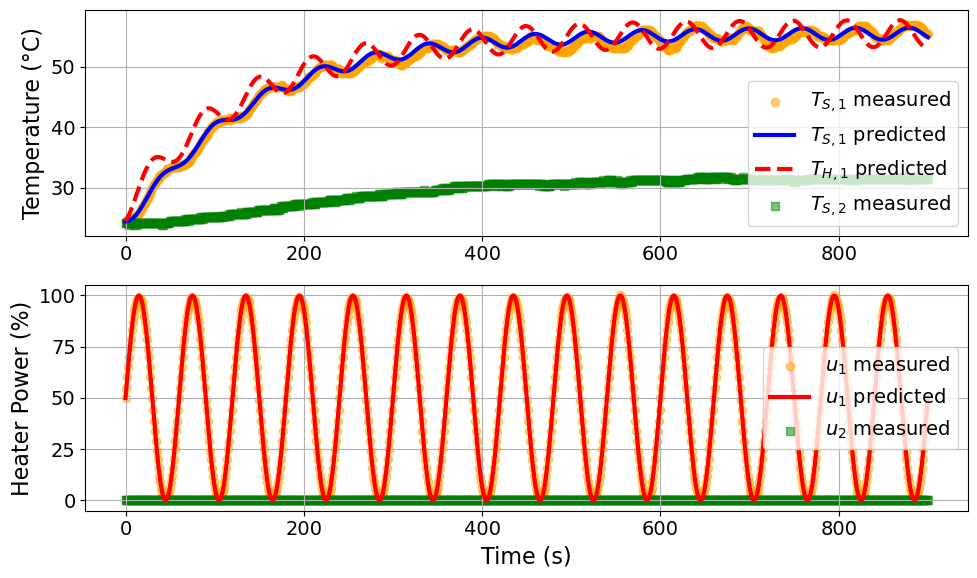

Model parameters:
Ua = 0.0515 Watts/degC
Ub = 0.0005 Watts/degC
CpH = 6.8386 Joules/degC
CpS = 0.01 Joules/degC
u1_period = 1.0 minutes
u1_amplitude = 50 % power
 


In [12]:
def create_model_sens(theta=theta_values):
    '''This function creates a model with the given data and theta values'''
    return create_model(
        data=tc_data,
        mode='doe',
        theta=theta,
        number_of_states=number_tclab_states,
        sine_period=1.0,
        sine_amplitude=50,
    )


# Get time points for control decisions
t_control = tc_data.time

measurements2 = MeasurementVariables()
measurements2.add_variables('Ts1', indices={0: t_control}, time_index_position=0)

decisions2 = DesignVariables()
decisions2.add_variables(
    'u1_period',
    indices=None,
    time_index_position=None,
    lower_bounds=10 / 60,
    upper_bounds=10,
    values=1.0,
)

decisions2.add_variables(
    'u1_amplitude',
    indices=None,
    time_index_position=None,
    lower_bounds=0,
    upper_bounds=50,
    values=50,
)


solver = SolverFactory('ipopt')
# solver.options['bound_push'] = 1E-10
solver.options['halt_on_ampl_error'] = 'yes'
# solver.options['tol'] = 1E-5
# solver.options['acceptable_tol'] = 1E-4
solver.options['max_iter'] = 1000
solver.options['linear_solver'] = 'ma57'

import logging

# Create doe_object using DesignOfExperiments
doe_object2 = DesignOfExperiments(
    theta_values,  # dictionary of parameters
    decisions2,  # design variable
    measurements2,  # measurement variable
    create_model_sens,  # model
    solver=solver,
    logger_level=logging.DEBUG,
)


result = doe_object2.compute_FIM(mode='sequential_finite', formula='central')

result.result_analysis()


pyomo_doe_results = extract_plot_results(tc_data, doe_object2.model)

In [13]:
results_summary(result)

======Results Summary======
Four design criteria log10() value:
A-optimality: 9.705521668583316
D-optimality: nan
E-optimality: nan
Modified E-optimality: nan

FIM:
 [[ 1.92187689e+08 -1.95158832e+08 -8.40569881e+06 -1.06170169e+03]
 [-1.95158832e+08  4.88231745e+09  6.63743245e+07  2.62025550e+04]
 [-8.40569881e+06  6.63743245e+07  1.49550678e+06  3.57695899e+02]
 [-1.06170169e+03  2.62025550e+04  3.57695899e+02  1.40628265e-01]]

eigenvalues:
 [ 4.89133300e+09  1.84254423e+08  4.13222899e+05 -2.71839065e-16]

eigenvectors:
 [[ 4.15154255e-02 -9.98649054e-01  3.12495844e-02 -1.00933074e-13]
 [-9.99044858e-01 -4.19179925e-02 -1.23390827e-02 -5.33299017e-06]
 [-1.36323331e-02  3.07074744e-02  9.99435446e-01 -2.48897568e-06]
 [-5.36182695e-06 -1.47118186e-07  2.42176631e-06  1.00000000e+00]]


This parameterization reproduced the original sine wave experiment. As expected, the FIM is still rank deficient.

## Perform sensitivity analysis to sine wave frequency and period

Now let's perform a sensitivity analysis over $p$ and $a$. `Pyomo.DoE` includes functions to automate this analysis including visualization. In our experience, an exploratory analysis like this is especially helpful to develop intuition about the physical system and model.

In [14]:
# Design variable ranges as lists

quick_run = False

if not quick_run:
    # Larger sensitivity analysis with more detailed plots
    design_ranges = {
        "u1_period": [1, 2, 3, 4, 5, 6, 7, 8],
        "u1_amplitude": [15, 25, 35, 45],
    }

else:
    # Faster sensitivity analysis, good for debugging
    design_ranges = {"u1_period": [1, 2], "u1_amplitude": [20, 50]}

# Choose from 'sequential_finite', 'direct_kaug'
sensi_opt = "sequential_finite"
# sensi_opt = "direct_kaug"

INFO: =======Iteration Number: 1 =====
DEBUG: Design variable values of this iteration: {'u1_period': 1,
'u1_amplitude': 15}
INFO: elapsed time: 7.7 seconds
INFO: This is run 1 out of 32.
INFO: The code has run  7.7 seconds.
INFO: Estimated remaining time:  238.68 seconds


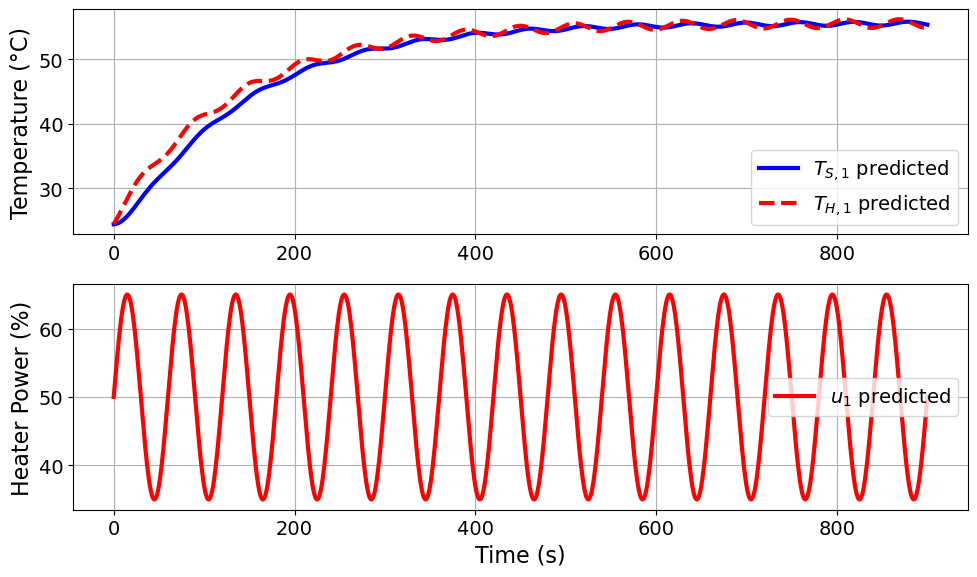

Model parameters:
Ua = 0.0515 Watts/degC
Ub = 0.0005 Watts/degC
CpH = 6.8386 Joules/degC
CpS = 0.01 Joules/degC
u1_period = 1 minutes
u1_amplitude = 15 % power
 
INFO: =======Iteration Number: 2 =====
DEBUG: Design variable values of this iteration: {'u1_period': 1,
'u1_amplitude': 25}
INFO: elapsed time: 7.6 seconds
INFO: This is run 2 out of 32.
INFO: The code has run  15.35 seconds.
INFO: Estimated remaining time:  230.3 seconds


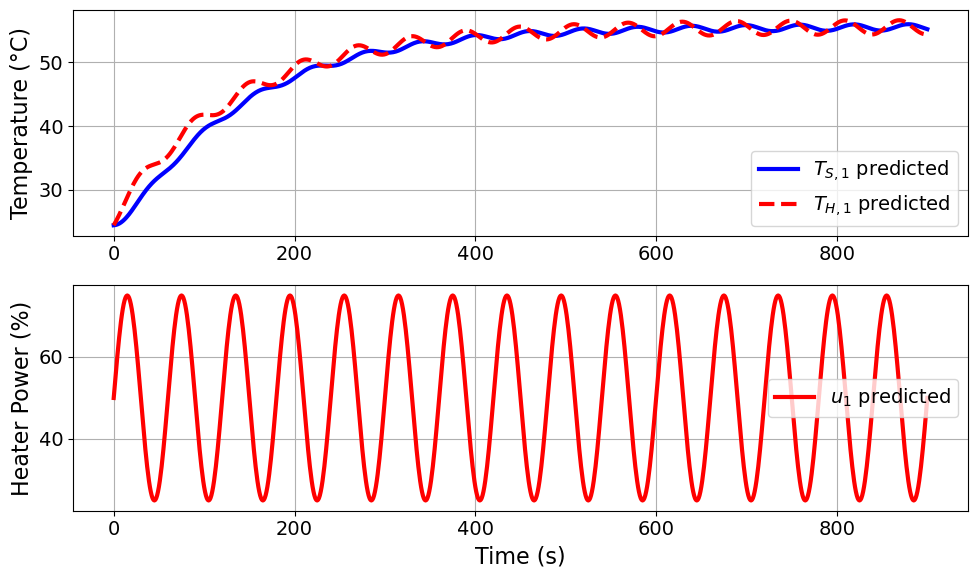

Model parameters:
Ua = 0.0515 Watts/degC
Ub = 0.0005 Watts/degC
CpH = 6.8386 Joules/degC
CpS = 0.01 Joules/degC
u1_period = 1 minutes
u1_amplitude = 25 % power
 
INFO: =======Iteration Number: 3 =====
DEBUG: Design variable values of this iteration: {'u1_period': 1,
'u1_amplitude': 35}
INFO: elapsed time: 7.8 seconds
INFO: This is run 3 out of 32.
INFO: The code has run  23.18 seconds.
INFO: Estimated remaining time:  224.03 seconds


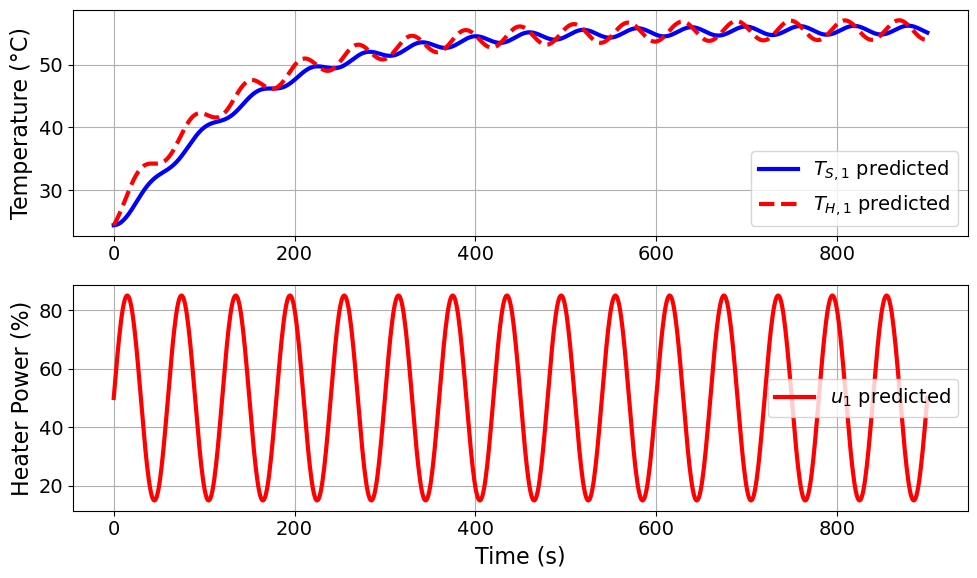

Model parameters:
Ua = 0.0515 Watts/degC
Ub = 0.0005 Watts/degC
CpH = 6.8386 Joules/degC
CpS = 0.01 Joules/degC
u1_period = 1 minutes
u1_amplitude = 35 % power
 
INFO: =======Iteration Number: 4 =====
DEBUG: Design variable values of this iteration: {'u1_period': 1,
'u1_amplitude': 45}
INFO: elapsed time: 7.8 seconds
INFO: This is run 4 out of 32.
INFO: The code has run  31.01 seconds.
INFO: Estimated remaining time:  217.06 seconds


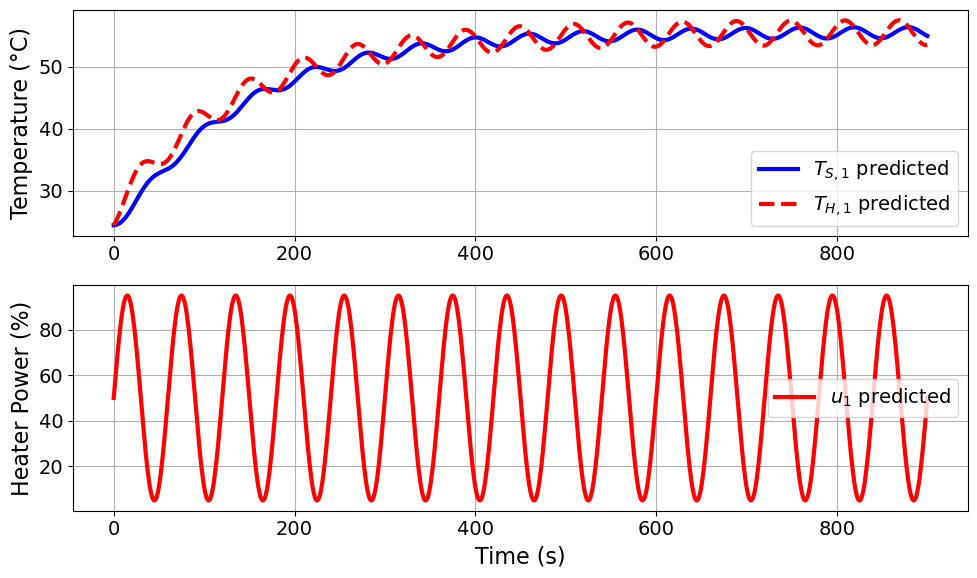

Model parameters:
Ua = 0.0515 Watts/degC
Ub = 0.0005 Watts/degC
CpH = 6.8386 Joules/degC
CpS = 0.01 Joules/degC
u1_period = 1 minutes
u1_amplitude = 45 % power
 
INFO: =======Iteration Number: 5 =====
DEBUG: Design variable values of this iteration: {'u1_period': 2,
'u1_amplitude': 15}
INFO: elapsed time: 27.1 seconds
INFO: This is run 5 out of 32.
INFO: The code has run  58.1 seconds.
INFO: Estimated remaining time:  313.74 seconds


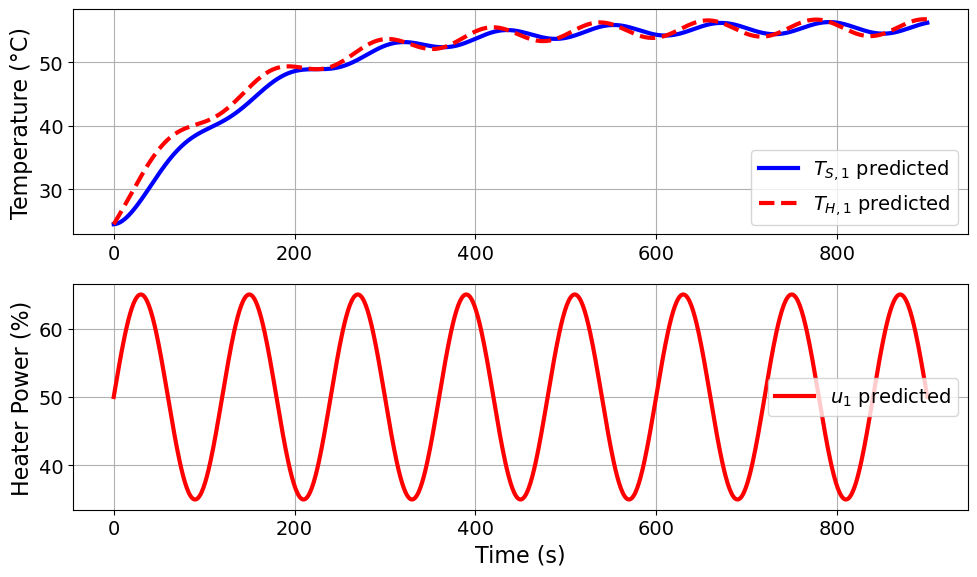

Model parameters:
Ua = 0.0515 Watts/degC
Ub = 0.0005 Watts/degC
CpH = 6.8386 Joules/degC
CpS = 0.01 Joules/degC
u1_period = 2 minutes
u1_amplitude = 15 % power
 
INFO: =======Iteration Number: 6 =====
DEBUG: Design variable values of this iteration: {'u1_period': 2,
'u1_amplitude': 25}
INFO: elapsed time: 18.3 seconds
INFO: This is run 6 out of 32.
INFO: The code has run  76.42 seconds.
INFO: Estimated remaining time:  331.13 seconds


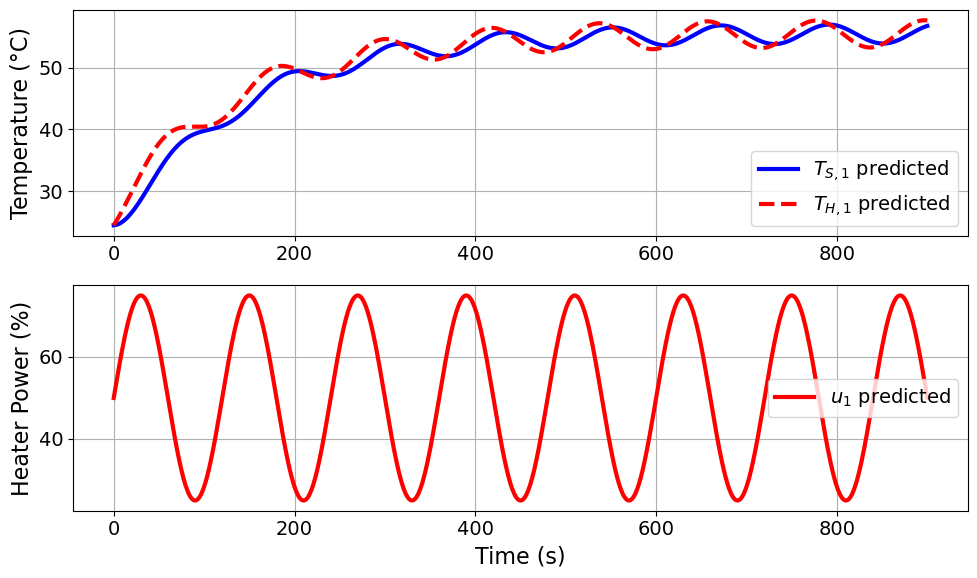

Model parameters:
Ua = 0.0515 Watts/degC
Ub = 0.0005 Watts/degC
CpH = 6.8386 Joules/degC
CpS = 0.01 Joules/degC
u1_period = 2 minutes
u1_amplitude = 25 % power
 
INFO: =======Iteration Number: 7 =====
DEBUG: Design variable values of this iteration: {'u1_period': 2,
'u1_amplitude': 35}
INFO: elapsed time: 13.5 seconds
INFO: This is run 7 out of 32.
INFO: The code has run  89.91 seconds.
INFO: Estimated remaining time:  321.11 seconds


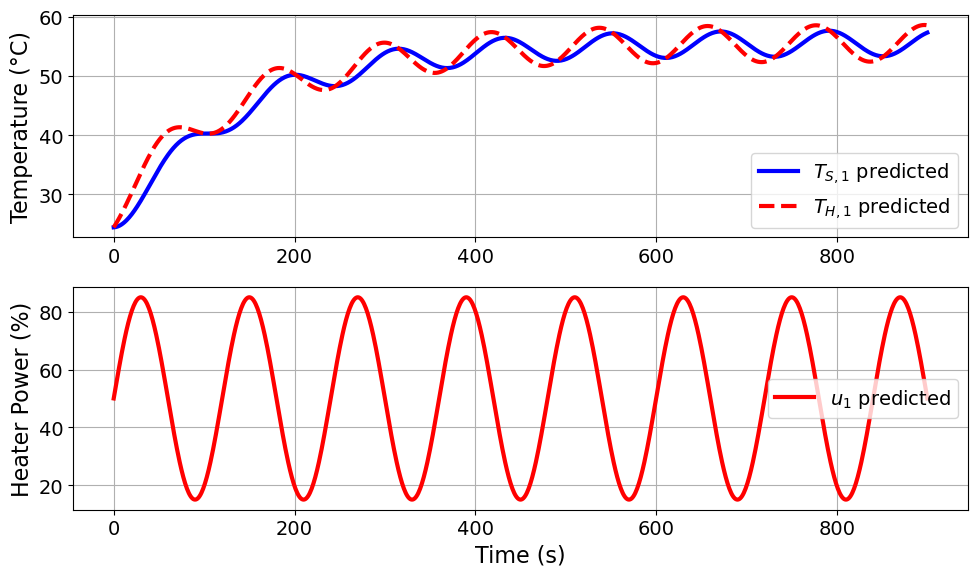

Model parameters:
Ua = 0.0515 Watts/degC
Ub = 0.0005 Watts/degC
CpH = 6.8386 Joules/degC
CpS = 0.01 Joules/degC
u1_period = 2 minutes
u1_amplitude = 35 % power
 
INFO: =======Iteration Number: 8 =====
DEBUG: Design variable values of this iteration: {'u1_period': 2,
'u1_amplitude': 45}
INFO: elapsed time: 22.3 seconds
INFO: This is run 8 out of 32.
INFO: The code has run  112.21 seconds.
INFO: Estimated remaining time:  336.62 seconds


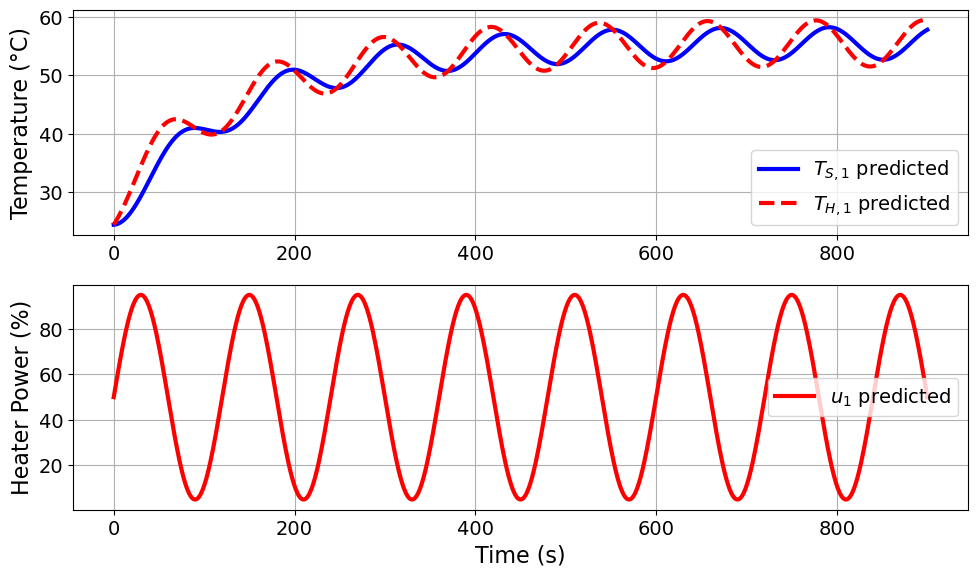

Model parameters:
Ua = 0.0515 Watts/degC
Ub = 0.0005 Watts/degC
CpH = 6.8386 Joules/degC
CpS = 0.01 Joules/degC
u1_period = 2 minutes
u1_amplitude = 45 % power
 
INFO: =======Iteration Number: 9 =====
DEBUG: Design variable values of this iteration: {'u1_period': 3,
'u1_amplitude': 15}
INFO: elapsed time: 29.4 seconds
INFO: This is run 9 out of 32.
INFO: The code has run  141.6 seconds.
INFO: Estimated remaining time:  361.87 seconds


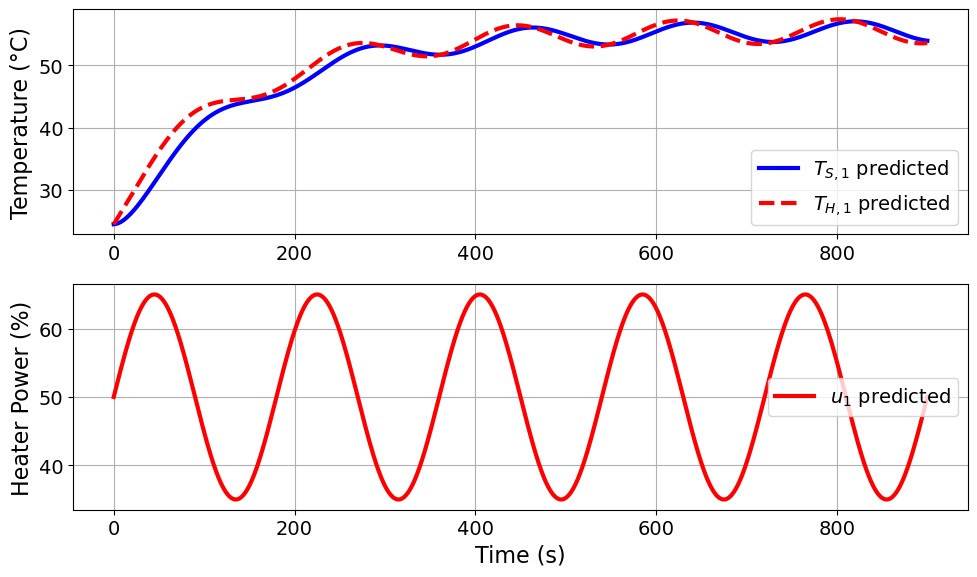

Model parameters:
Ua = 0.0515 Watts/degC
Ub = 0.0005 Watts/degC
CpH = 6.8386 Joules/degC
CpS = 0.01 Joules/degC
u1_period = 3 minutes
u1_amplitude = 15 % power
 
INFO: =======Iteration Number: 10 =====
DEBUG: Design variable values of this iteration: {'u1_period': 3,
'u1_amplitude': 25}
INFO: elapsed time: 23.3 seconds
INFO: This is run 10 out of 32.
INFO: The code has run  164.89 seconds.
INFO: Estimated remaining time:  362.77 seconds


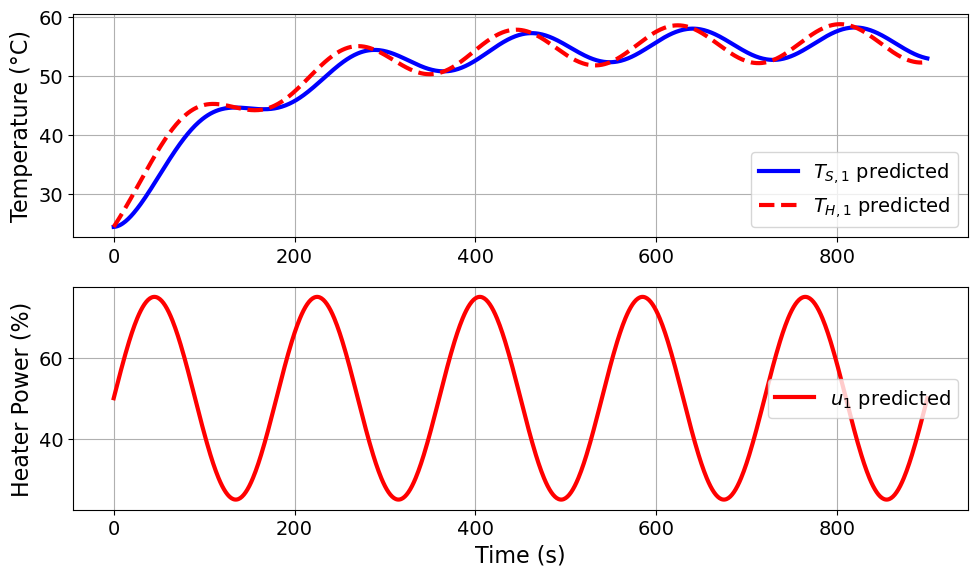

Model parameters:
Ua = 0.0515 Watts/degC
Ub = 0.0005 Watts/degC
CpH = 6.8386 Joules/degC
CpS = 0.01 Joules/degC
u1_period = 3 minutes
u1_amplitude = 25 % power
 
INFO: =======Iteration Number: 11 =====
DEBUG: Design variable values of this iteration: {'u1_period': 3,
'u1_amplitude': 35}
INFO: elapsed time: 16.0 seconds
INFO: This is run 11 out of 32.
INFO: The code has run  180.95 seconds.
INFO: Estimated remaining time:  345.45 seconds


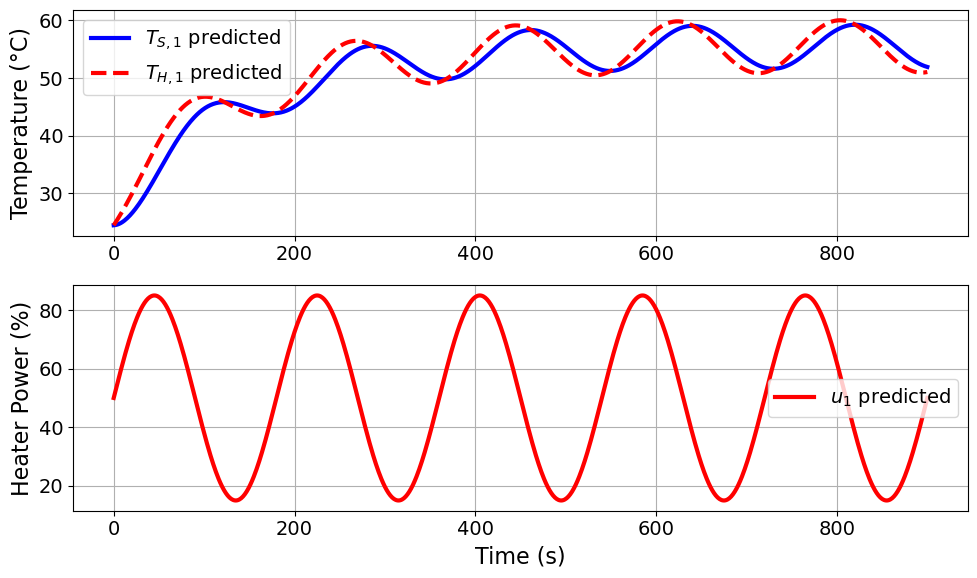

Model parameters:
Ua = 0.0515 Watts/degC
Ub = 0.0005 Watts/degC
CpH = 6.8386 Joules/degC
CpS = 0.01 Joules/degC
u1_period = 3 minutes
u1_amplitude = 35 % power
 
INFO: =======Iteration Number: 12 =====
DEBUG: Design variable values of this iteration: {'u1_period': 3,
'u1_amplitude': 45}
model.name="unknown";
    - termination condition: infeasible
    - message from solver: Ipopt 3.13.2\x3a Converged to a locally infeasible
      point. Problem may be infeasible.
INFO: elapsed time: 9.3 seconds
INFO: This is run 12 out of 32.
INFO: The code has run  190.23 seconds.
INFO: Estimated remaining time:  317.05 seconds


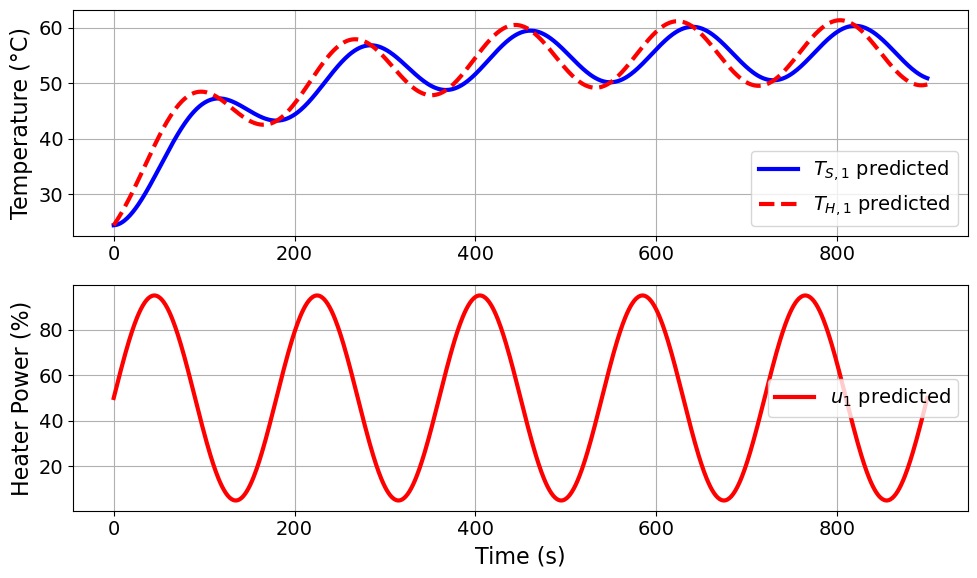

Model parameters:
Ua = 0.0515 Watts/degC
Ub = 0.0005 Watts/degC
CpH = 6.8386 Joules/degC
CpS = 0.01 Joules/degC
u1_period = 3 minutes
u1_amplitude = 45 % power
 
INFO: =======Iteration Number: 13 =====
DEBUG: Design variable values of this iteration: {'u1_period': 4,
'u1_amplitude': 15}
INFO: elapsed time: 39.9 seconds
INFO: This is run 13 out of 32.
INFO: The code has run  230.17 seconds.
INFO: Estimated remaining time:  336.4 seconds


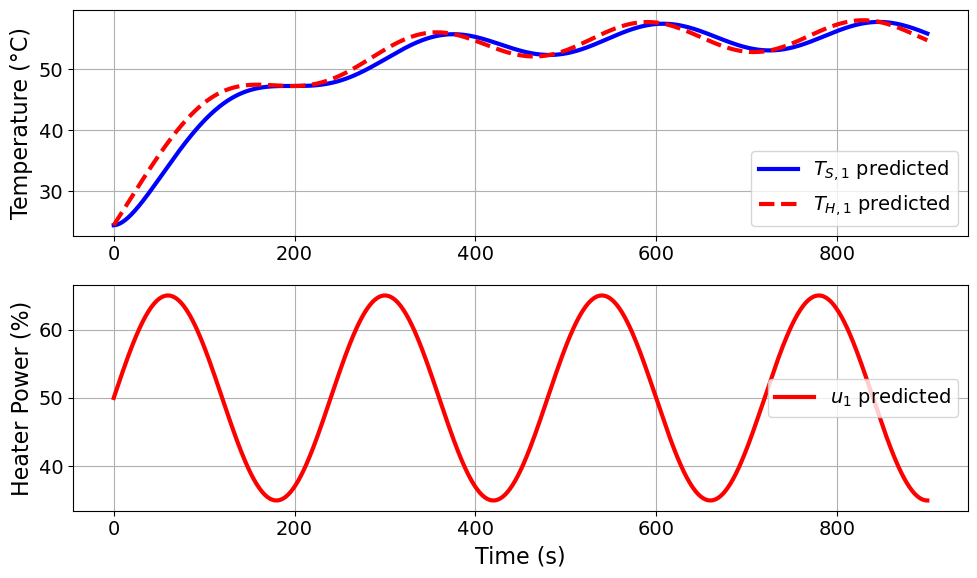

Model parameters:
Ua = 0.0515 Watts/degC
Ub = 0.0005 Watts/degC
CpH = 6.8386 Joules/degC
CpS = 0.01 Joules/degC
u1_period = 4 minutes
u1_amplitude = 15 % power
 
INFO: =======Iteration Number: 14 =====
DEBUG: Design variable values of this iteration: {'u1_period': 4,
'u1_amplitude': 25}
INFO: elapsed time: 34.8 seconds
INFO: This is run 14 out of 32.
INFO: The code has run  265.01 seconds.
INFO: Estimated remaining time:  340.72 seconds


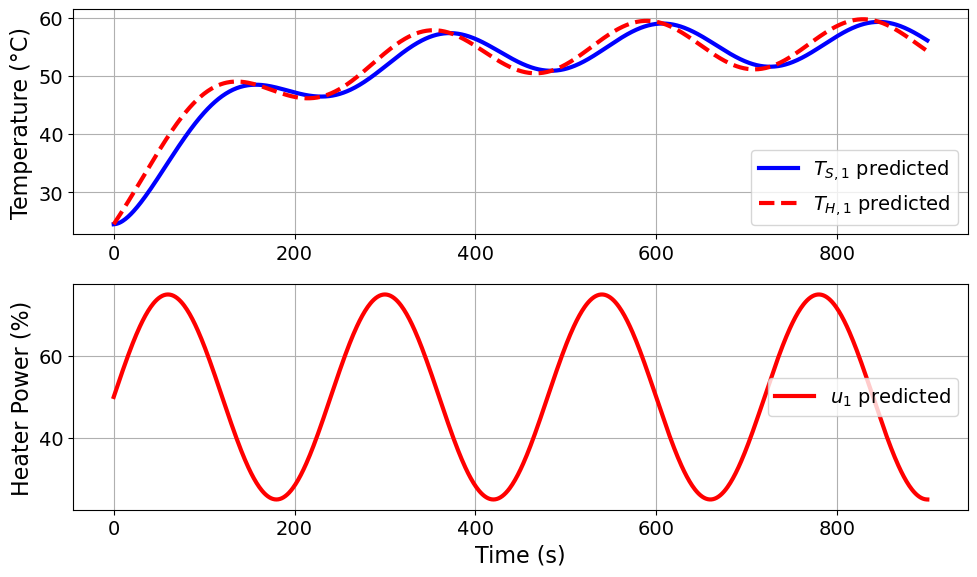

Model parameters:
Ua = 0.0515 Watts/degC
Ub = 0.0005 Watts/degC
CpH = 6.8386 Joules/degC
CpS = 0.01 Joules/degC
u1_period = 4 minutes
u1_amplitude = 25 % power
 
INFO: =======Iteration Number: 15 =====
DEBUG: Design variable values of this iteration: {'u1_period': 4,
'u1_amplitude': 35}
INFO: elapsed time: 16.6 seconds
INFO: This is run 15 out of 32.
INFO: The code has run  281.56 seconds.
INFO: Estimated remaining time:  319.1 seconds


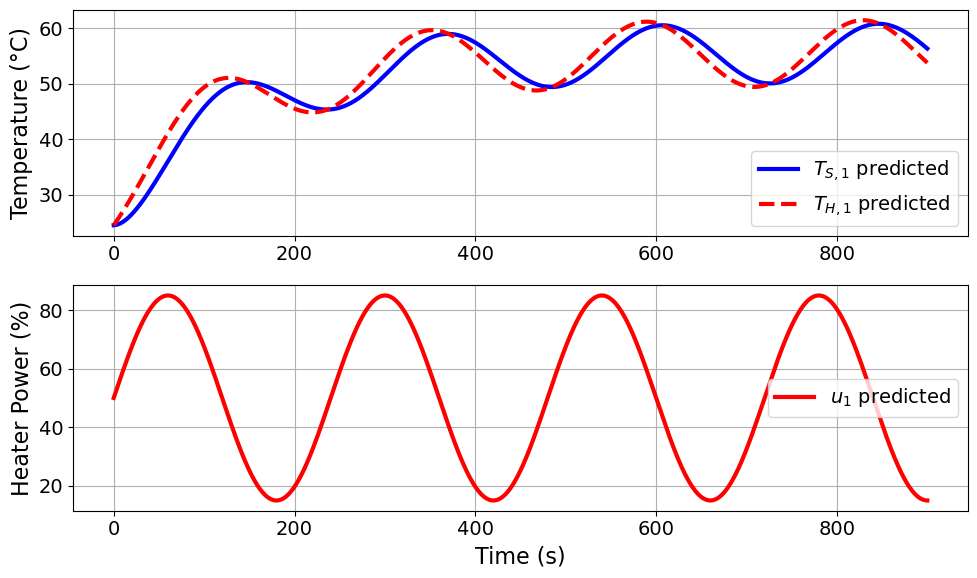

Model parameters:
Ua = 0.0515 Watts/degC
Ub = 0.0005 Watts/degC
CpH = 6.8386 Joules/degC
CpS = 0.01 Joules/degC
u1_period = 4 minutes
u1_amplitude = 35 % power
 
INFO: =======Iteration Number: 16 =====
DEBUG: Design variable values of this iteration: {'u1_period': 4,
'u1_amplitude': 45}
model.name="unknown";
    - termination condition: infeasible
    - message from solver: Ipopt 3.13.2\x3a Converged to a locally infeasible
      point. Problem may be infeasible.
INFO: elapsed time: 9.2 seconds
INFO: This is run 16 out of 32.
INFO: The code has run  290.75 seconds.
INFO: Estimated remaining time:  290.75 seconds


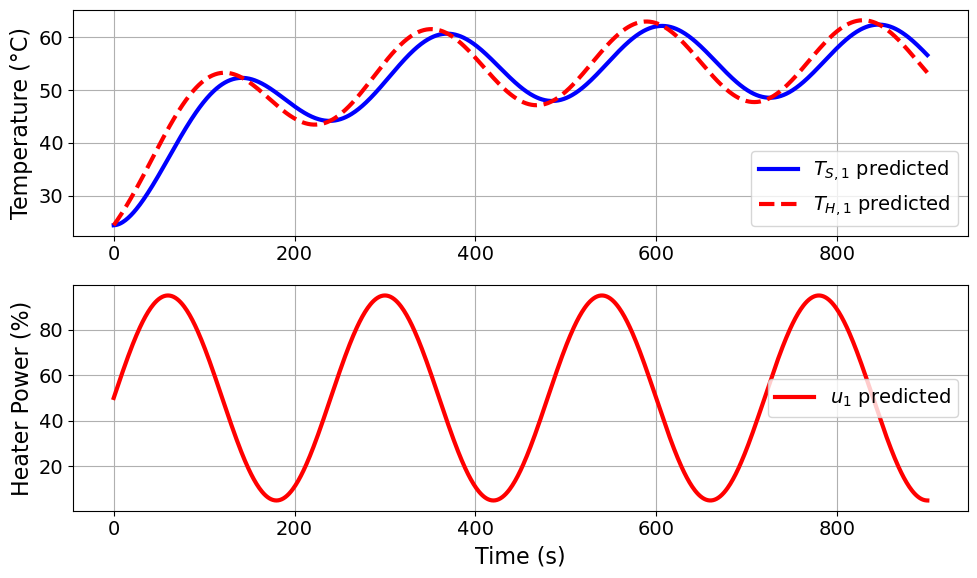

Model parameters:
Ua = 0.0515 Watts/degC
Ub = 0.0005 Watts/degC
CpH = 6.8386 Joules/degC
CpS = 0.01 Joules/degC
u1_period = 4 minutes
u1_amplitude = 45 % power
 
INFO: =======Iteration Number: 17 =====
DEBUG: Design variable values of this iteration: {'u1_period': 5,
'u1_amplitude': 15}
INFO: elapsed time: 37.8 seconds
INFO: This is run 17 out of 32.
INFO: The code has run  328.51 seconds.
INFO: Estimated remaining time:  289.86 seconds


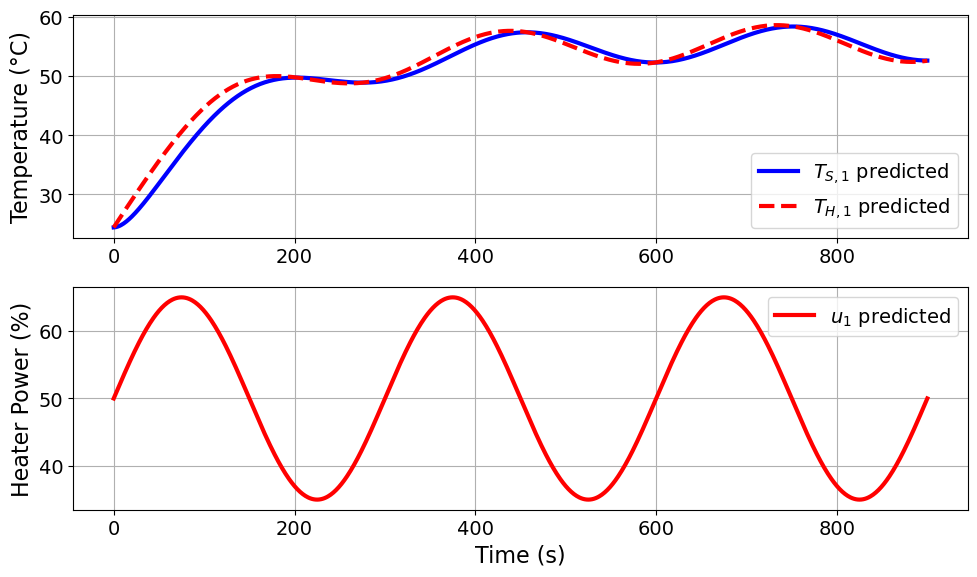

Model parameters:
Ua = 0.0515 Watts/degC
Ub = 0.0005 Watts/degC
CpH = 6.8386 Joules/degC
CpS = 0.01 Joules/degC
u1_period = 5 minutes
u1_amplitude = 15 % power
 
INFO: =======Iteration Number: 18 =====
DEBUG: Design variable values of this iteration: {'u1_period': 5,
'u1_amplitude': 25}
INFO: elapsed time: 23.9 seconds
INFO: This is run 18 out of 32.
INFO: The code has run  352.37 seconds.
INFO: Estimated remaining time:  274.07 seconds


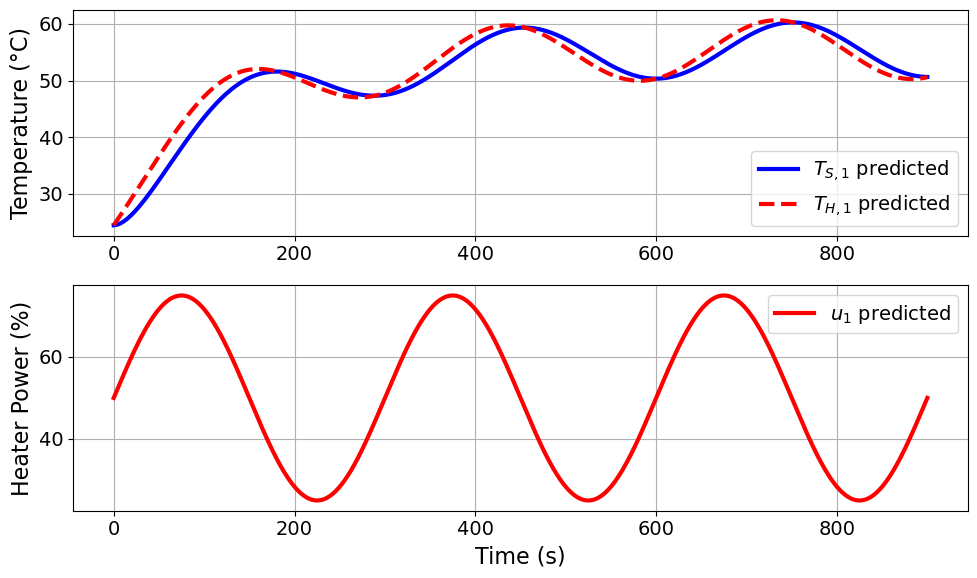

Model parameters:
Ua = 0.0515 Watts/degC
Ub = 0.0005 Watts/degC
CpH = 6.8386 Joules/degC
CpS = 0.01 Joules/degC
u1_period = 5 minutes
u1_amplitude = 25 % power
 
INFO: =======Iteration Number: 19 =====
DEBUG: Design variable values of this iteration: {'u1_period': 5,
'u1_amplitude': 35}
INFO: elapsed time: 17.2 seconds
INFO: This is run 19 out of 32.
INFO: The code has run  369.56 seconds.
INFO: Estimated remaining time:  252.86 seconds


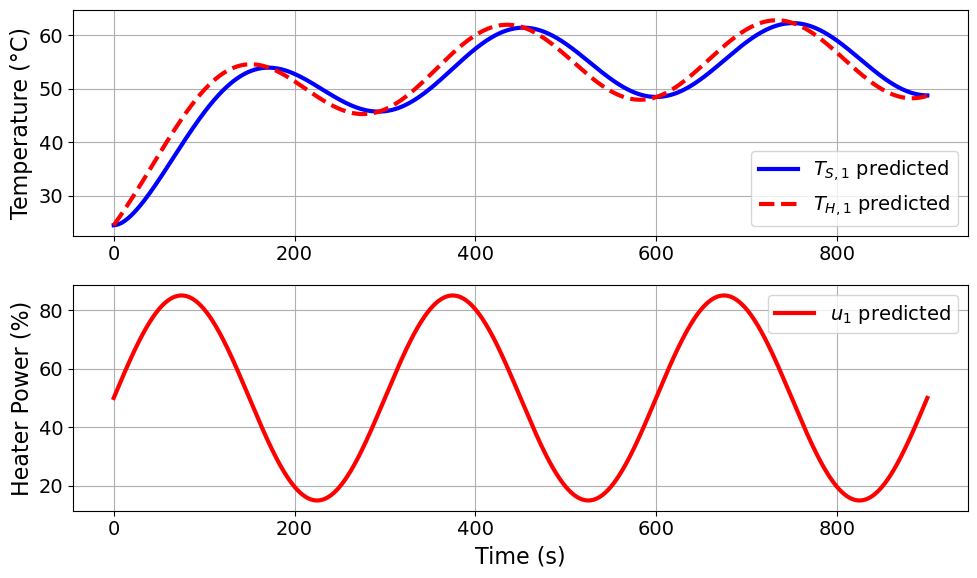

Model parameters:
Ua = 0.0515 Watts/degC
Ub = 0.0005 Watts/degC
CpH = 6.8386 Joules/degC
CpS = 0.01 Joules/degC
u1_period = 5 minutes
u1_amplitude = 35 % power
 
INFO: =======Iteration Number: 20 =====
DEBUG: Design variable values of this iteration: {'u1_period': 5,
'u1_amplitude': 45}
INFO: elapsed time: 33.2 seconds
INFO: This is run 20 out of 32.
INFO: The code has run  402.81 seconds.
INFO: Estimated remaining time:  241.69 seconds


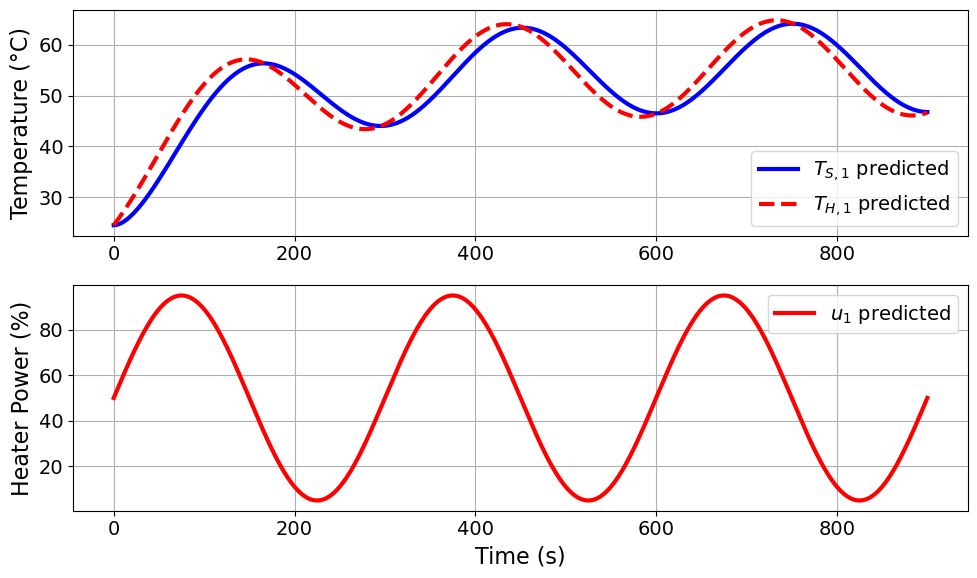

Model parameters:
Ua = 0.0515 Watts/degC
Ub = 0.0005 Watts/degC
CpH = 6.8386 Joules/degC
CpS = 0.01 Joules/degC
u1_period = 5 minutes
u1_amplitude = 45 % power
 
INFO: =======Iteration Number: 21 =====
DEBUG: Design variable values of this iteration: {'u1_period': 6,
'u1_amplitude': 15}
INFO: elapsed time: 47.5 seconds
INFO: This is run 21 out of 32.
INFO: The code has run  450.3 seconds.
INFO: Estimated remaining time:  235.87 seconds


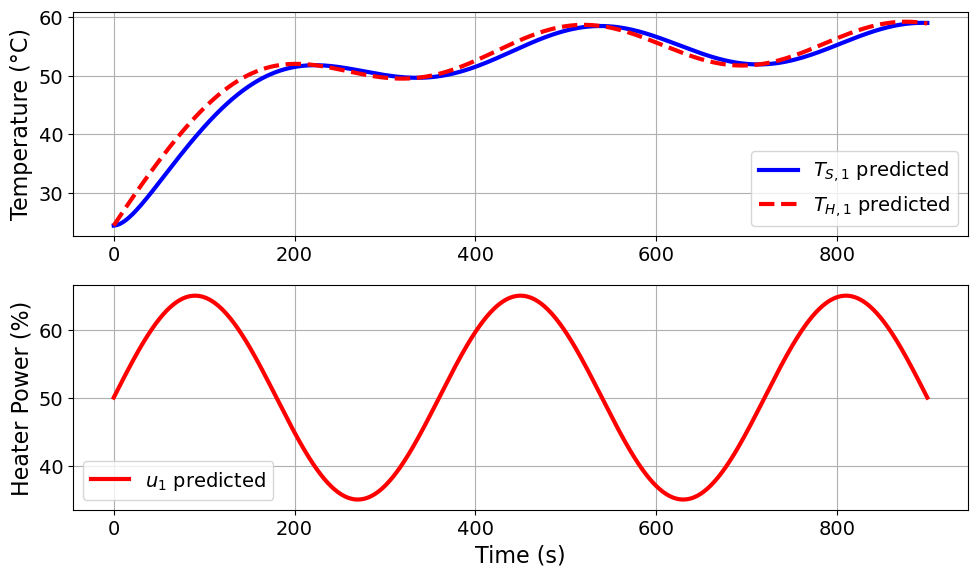

Model parameters:
Ua = 0.0515 Watts/degC
Ub = 0.0005 Watts/degC
CpH = 6.8386 Joules/degC
CpS = 0.01 Joules/degC
u1_period = 6 minutes
u1_amplitude = 15 % power
 
INFO: =======Iteration Number: 22 =====
DEBUG: Design variable values of this iteration: {'u1_period': 6,
'u1_amplitude': 25}
INFO: elapsed time: 30.8 seconds
INFO: This is run 22 out of 32.
INFO: The code has run  481.15 seconds.
INFO: Estimated remaining time:  218.7 seconds


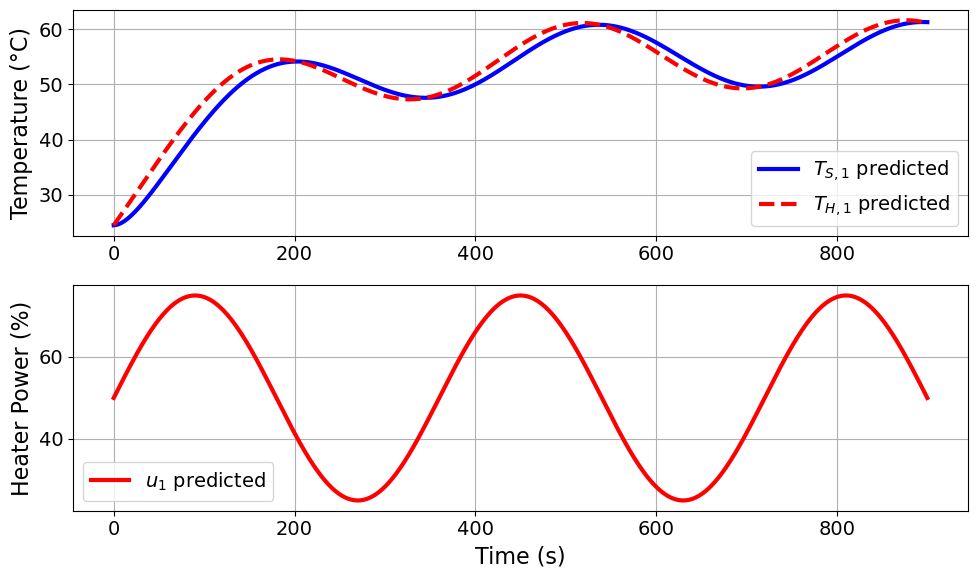

Model parameters:
Ua = 0.0515 Watts/degC
Ub = 0.0005 Watts/degC
CpH = 6.8386 Joules/degC
CpS = 0.01 Joules/degC
u1_period = 6 minutes
u1_amplitude = 25 % power
 
INFO: =======Iteration Number: 23 =====
DEBUG: Design variable values of this iteration: {'u1_period': 6,
'u1_amplitude': 35}
INFO: elapsed time: 18.9 seconds
INFO: This is run 23 out of 32.
INFO: The code has run  500.03 seconds.
INFO: Estimated remaining time:  195.66 seconds


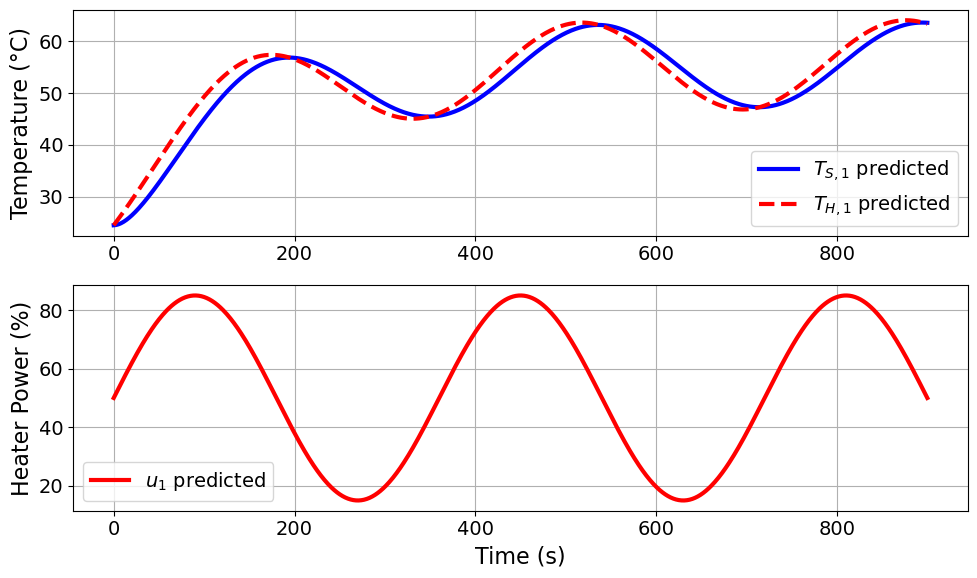

Model parameters:
Ua = 0.0515 Watts/degC
Ub = 0.0005 Watts/degC
CpH = 6.8386 Joules/degC
CpS = 0.01 Joules/degC
u1_period = 6 minutes
u1_amplitude = 35 % power
 
INFO: =======Iteration Number: 24 =====
DEBUG: Design variable values of this iteration: {'u1_period': 6,
'u1_amplitude': 45}
model.name="unknown";
    - termination condition: infeasible
    - message from solver: Ipopt 3.13.2\x3a Converged to a locally infeasible
      point. Problem may be infeasible.
INFO: elapsed time: 9.0 seconds
INFO: This is run 24 out of 32.
INFO: The code has run  509.07 seconds.
INFO: Estimated remaining time:  169.69 seconds


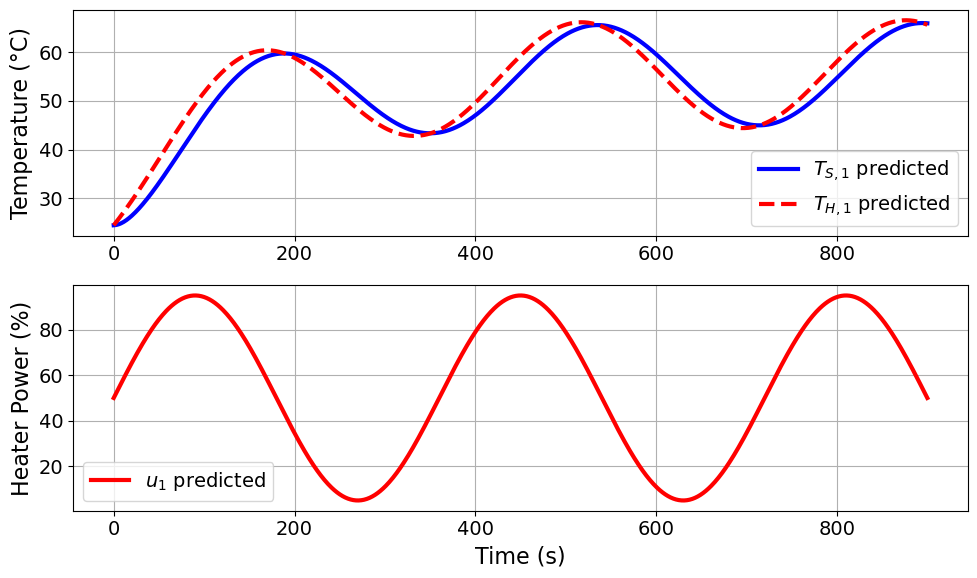

Model parameters:
Ua = 0.0515 Watts/degC
Ub = 0.0005 Watts/degC
CpH = 6.8386 Joules/degC
CpS = 0.01 Joules/degC
u1_period = 6 minutes
u1_amplitude = 45 % power
 
INFO: =======Iteration Number: 25 =====
DEBUG: Design variable values of this iteration: {'u1_period': 7,
'u1_amplitude': 15}
INFO: elapsed time: 37.1 seconds
INFO: This is run 25 out of 32.
INFO: The code has run  546.13 seconds.
INFO: Estimated remaining time:  152.92 seconds


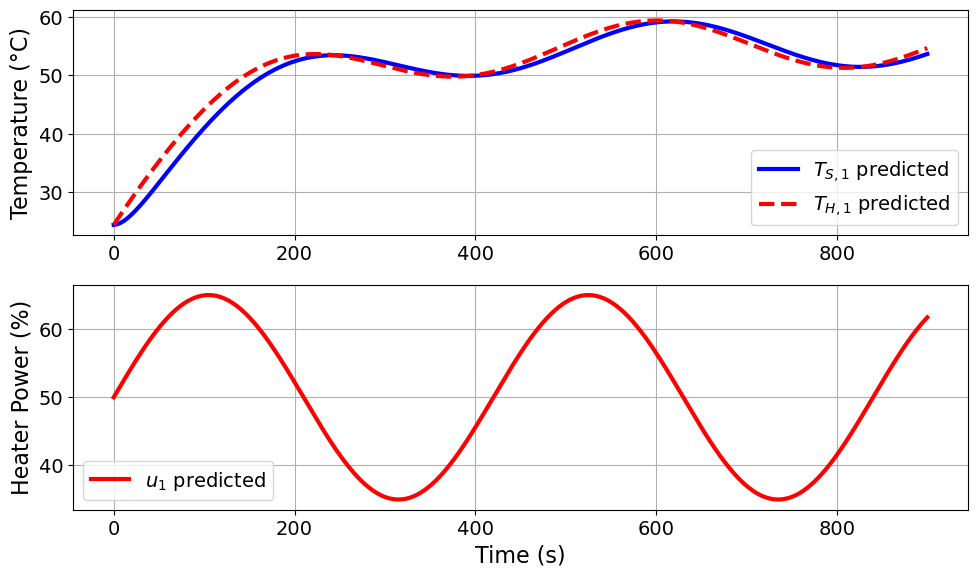

Model parameters:
Ua = 0.0515 Watts/degC
Ub = 0.0005 Watts/degC
CpH = 6.8386 Joules/degC
CpS = 0.01 Joules/degC
u1_period = 7 minutes
u1_amplitude = 15 % power
 
INFO: =======Iteration Number: 26 =====
DEBUG: Design variable values of this iteration: {'u1_period': 7,
'u1_amplitude': 25}
INFO: elapsed time: 31.6 seconds
INFO: This is run 26 out of 32.
INFO: The code has run  577.69 seconds.
INFO: Estimated remaining time:  133.31 seconds


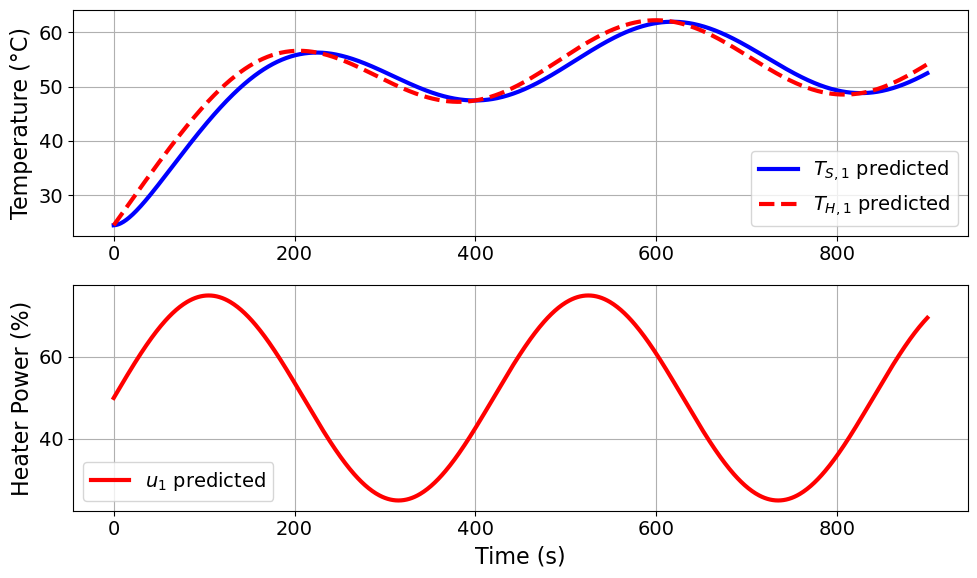

Model parameters:
Ua = 0.0515 Watts/degC
Ub = 0.0005 Watts/degC
CpH = 6.8386 Joules/degC
CpS = 0.01 Joules/degC
u1_period = 7 minutes
u1_amplitude = 25 % power
 
INFO: =======Iteration Number: 27 =====
DEBUG: Design variable values of this iteration: {'u1_period': 7,
'u1_amplitude': 35}
INFO: elapsed time: 19.3 seconds
INFO: This is run 27 out of 32.
INFO: The code has run  596.97 seconds.
INFO: Estimated remaining time:  110.55 seconds


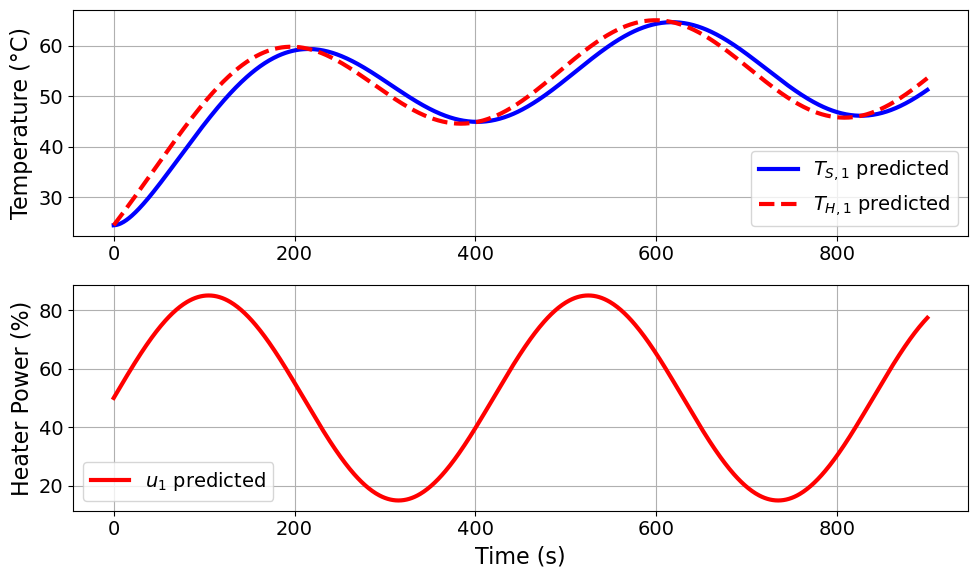

Model parameters:
Ua = 0.0515 Watts/degC
Ub = 0.0005 Watts/degC
CpH = 6.8386 Joules/degC
CpS = 0.01 Joules/degC
u1_period = 7 minutes
u1_amplitude = 35 % power
 
INFO: =======Iteration Number: 28 =====
DEBUG: Design variable values of this iteration: {'u1_period': 7,
'u1_amplitude': 45}
INFO: elapsed time: 34.3 seconds
INFO: This is run 28 out of 32.
INFO: The code has run  631.24 seconds.
INFO: Estimated remaining time:  90.18 seconds


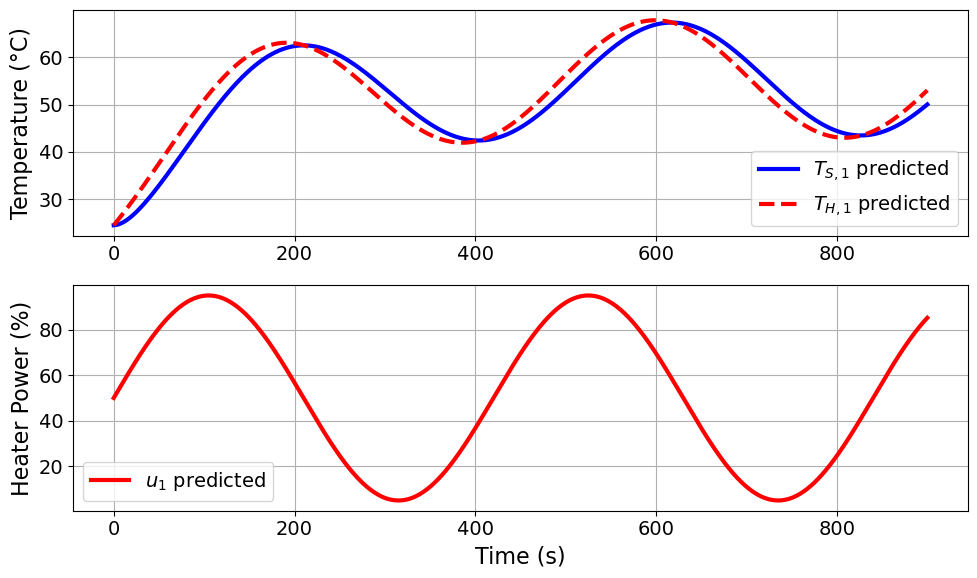

Model parameters:
Ua = 0.0515 Watts/degC
Ub = 0.0005 Watts/degC
CpH = 6.8386 Joules/degC
CpS = 0.01 Joules/degC
u1_period = 7 minutes
u1_amplitude = 45 % power
 
INFO: =======Iteration Number: 29 =====
DEBUG: Design variable values of this iteration: {'u1_period': 8,
'u1_amplitude': 15}
INFO: elapsed time: 47.1 seconds
INFO: This is run 29 out of 32.
INFO: The code has run  678.32 seconds.
INFO: Estimated remaining time:  70.17 seconds


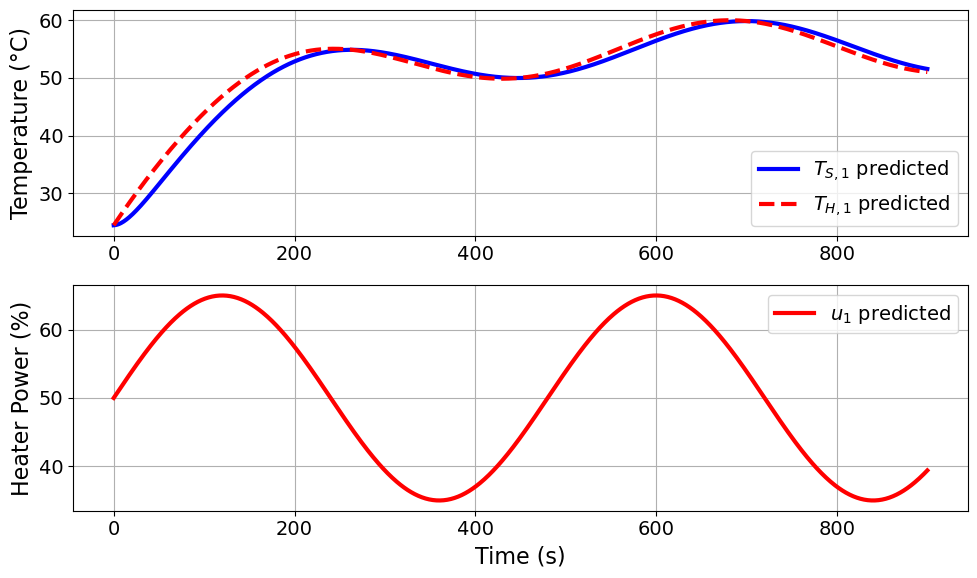

Model parameters:
Ua = 0.0515 Watts/degC
Ub = 0.0005 Watts/degC
CpH = 6.8386 Joules/degC
CpS = 0.01 Joules/degC
u1_period = 8 minutes
u1_amplitude = 15 % power
 
INFO: =======Iteration Number: 30 =====
DEBUG: Design variable values of this iteration: {'u1_period': 8,
'u1_amplitude': 25}
INFO: elapsed time: 28.7 seconds
INFO: This is run 30 out of 32.
INFO: The code has run  707.06 seconds.
INFO: Estimated remaining time:  47.14 seconds


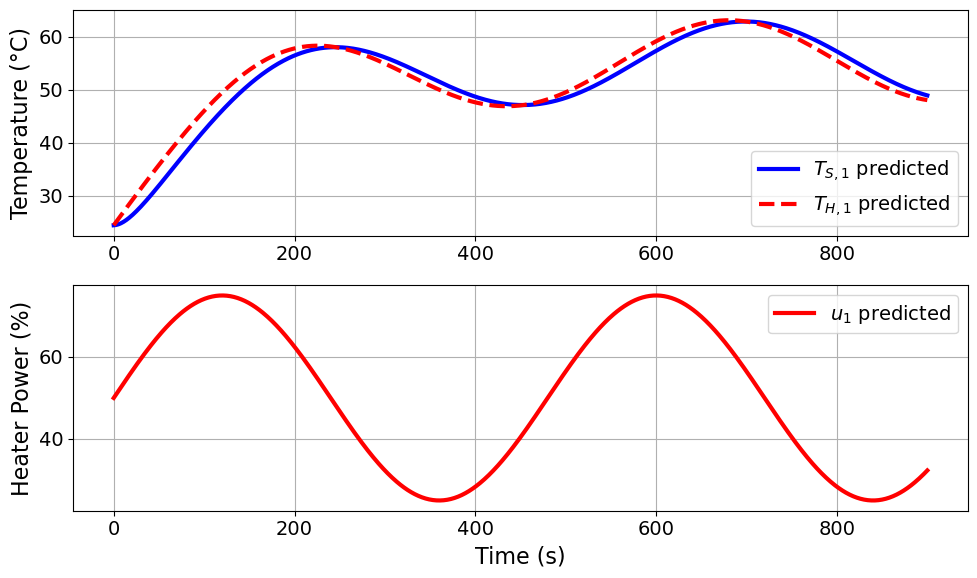

Model parameters:
Ua = 0.0515 Watts/degC
Ub = 0.0005 Watts/degC
CpH = 6.8386 Joules/degC
CpS = 0.01 Joules/degC
u1_period = 8 minutes
u1_amplitude = 25 % power
 
INFO: =======Iteration Number: 31 =====
DEBUG: Design variable values of this iteration: {'u1_period': 8,
'u1_amplitude': 35}
INFO: elapsed time: 18.9 seconds
INFO: This is run 31 out of 32.
INFO: The code has run  725.97 seconds.
INFO: Estimated remaining time:  23.42 seconds


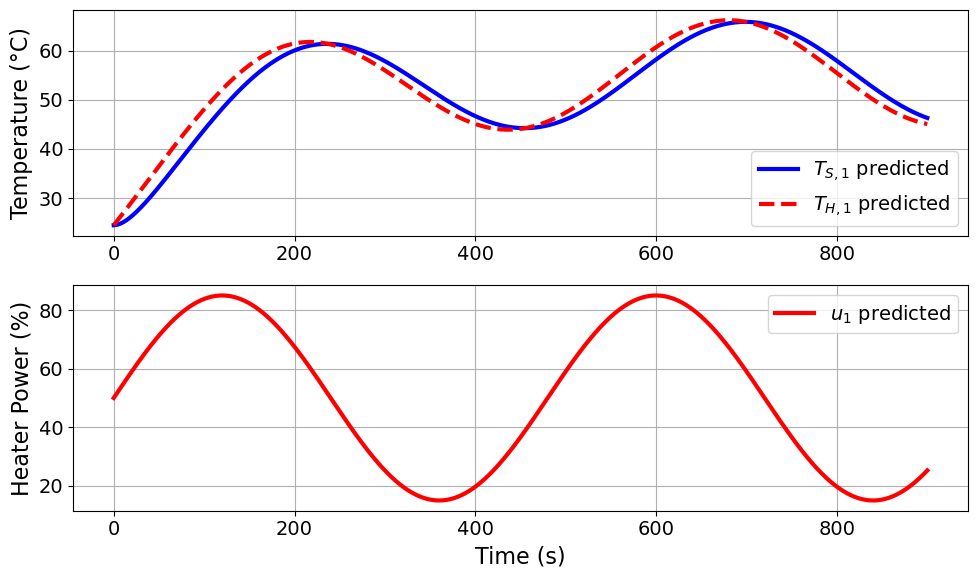

Model parameters:
Ua = 0.0515 Watts/degC
Ub = 0.0005 Watts/degC
CpH = 6.8386 Joules/degC
CpS = 0.01 Joules/degC
u1_period = 8 minutes
u1_amplitude = 35 % power
 
INFO: =======Iteration Number: 32 =====
DEBUG: Design variable values of this iteration: {'u1_period': 8,
'u1_amplitude': 45}
model.name="unknown";
    - termination condition: infeasible
    - message from solver: Ipopt 3.13.2\x3a Converged to a locally infeasible
      point. Problem may be infeasible.
INFO: elapsed time: 9.1 seconds
INFO: This is run 32 out of 32.
INFO: The code has run  735.09 seconds.
INFO: Estimated remaining time:  0.0 seconds


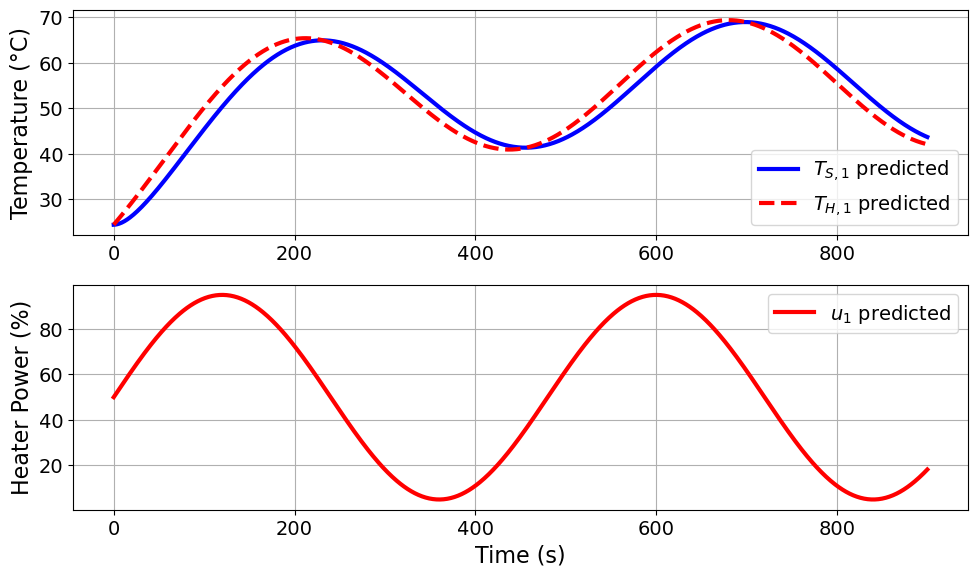

Model parameters:
Ua = 0.0515 Watts/degC
Ub = 0.0005 Watts/degC
CpH = 6.8386 Joules/degC
CpS = 0.01 Joules/degC
u1_period = 8 minutes
u1_amplitude = 45 % power
 
INFO: Overall wall clock time [s]:  735.0857825791463


In [15]:
plot_each_iteration = lambda mod: extract_plot_results(None, mod)

# Grid search
all_fim = doe_object2.run_grid_search(
    design_ranges,  # range of design variables
    mode=sensi_opt,  # solver option for sensitivity
    post_processing_function=plot_each_iteration,
)

## Visualize and interpret sensitivity analysis results

/Users/adowling/DowlingLab/pyomo/pyomo/contrib/doe/result.py:663: RuntimeWarning: invalid value encountered in log10
  hes_e = np.log10(self.cri_e)
/Users/adowling/DowlingLab/pyomo/pyomo/contrib/doe/result.py:664: RuntimeWarning: divide by zero encountered in log10
  hes_d = np.log10(self.cri_d)
/Users/adowling/DowlingLab/pyomo/pyomo/contrib/doe/result.py:664: RuntimeWarning: invalid value encountered in log10
  hes_d = np.log10(self.cri_d)
/Users/adowling/DowlingLab/pyomo/pyomo/contrib/doe/result.py:665: RuntimeWarning: invalid value encountered in log10
  hes_e2 = np.log10(self.cri_e_cond)


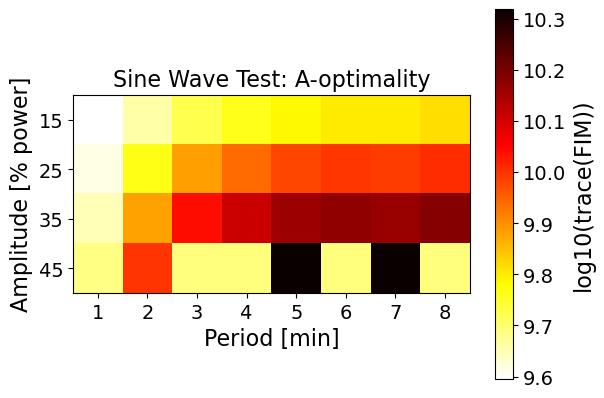

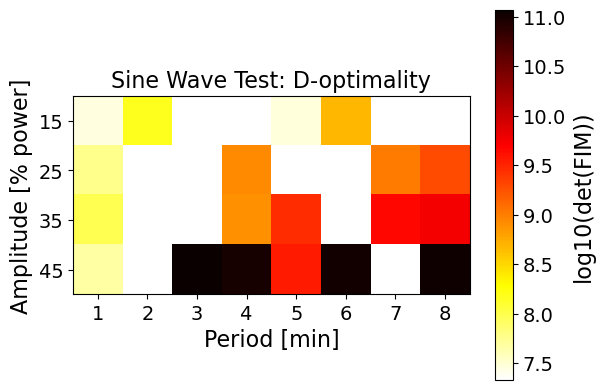

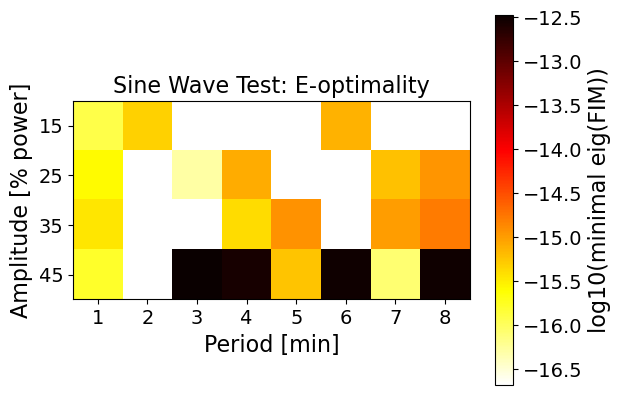

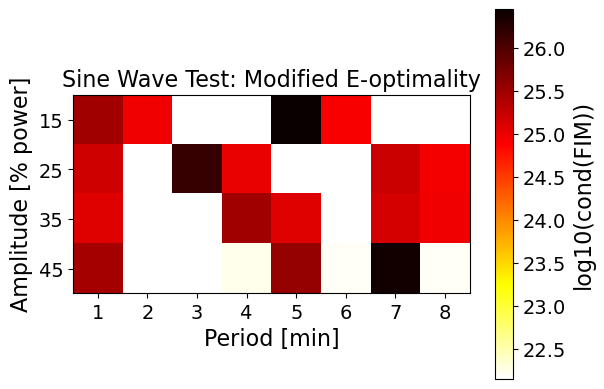

In [17]:
# Extract criteria from FIM
all_fim.extract_criteria()

# Make heat maps
all_fim.figure_drawing(
    {},  # Empty dictionary because the sensitivity analysis only included 2 dimensions.
    ["u1_period", "u1_amplitude"],
    "Sine Wave Test",
    "Period [min]",
    "Amplitude [% power]",
)